In [2]:
import os
import sys
import warnings
import logging

module_path = os.path.abspath('../src')
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from models.baseline_model import BaselineModel
from models.linear_model import LinearModel
from models.prophet_model import ProphetModel
from models.xgb_model import XGBModel
from models.lgb_model import LGBModel
from models.sarimax_model import SarimaxModel
from models.lstm_model import LSTMModel
from models.hybrid_model import HybridModel
from models.ensemble_model import EnsembleModel
from models.stacking_model import StackingModel
from utils.preprocessor import Preprocessor
from utils.model_selection import back_test, grid_search

warnings.filterwarnings('ignore')
logging.getLogger('prophet').setLevel(logging.WARNING)

%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Python39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Import data

Source: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=AEP_hourly.csv

In [3]:
df_raw = pd.read_csv('../data/AEP_hourly.csv', parse_dates=True, index_col='Datetime')
df = df_raw.loc['2017-01':'2017-06'].copy()
df.head()

,AEP_MW
Datetime,
2017-01-01 00:00:00,13240
2017-01-01 01:00:00,12876
2017-01-01 02:00:00,12591
2017-01-01 03:00:00,12487
2017-01-01 04:00:00,12369


Preprocess data

Percentage of outlier: 2.0257826887661143%


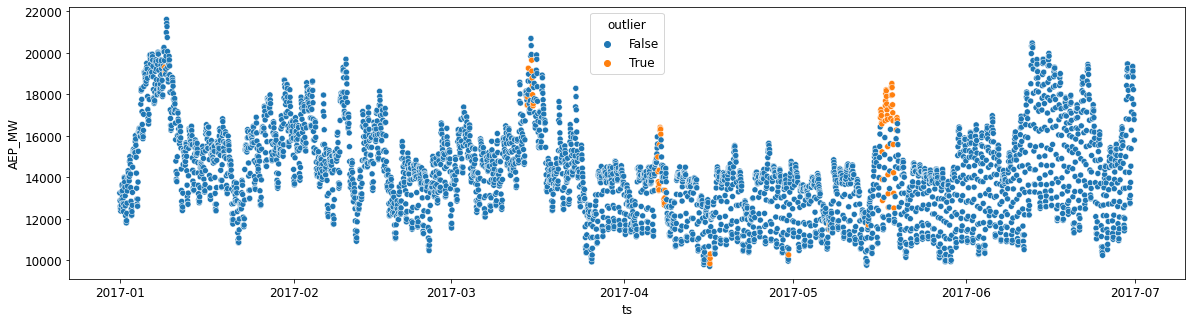

In [4]:
pp = Preprocessor(resample_freq='1h', agg='mean')
df_pp = pp.fit(df).transform(df)

Plot forecasts

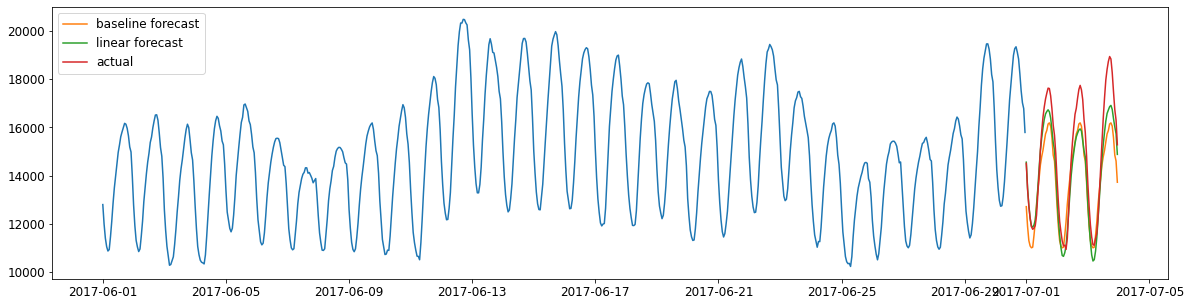

In [4]:
baseline = BaselineModel(freq='1h', horizon='3d')
res_baseline = baseline.fit(df_pp).predict(df_pp)

lasso = LinearModel(freq='1h', horizon='3d')
res_lasso = lasso.fit(df_pp).predict(df_pp)

plt.figure(figsize=(20,5))
plt.plot(df_pp.iloc[-24*30:].index, df_pp.iloc[-24*30:].values)
plt.plot(res_baseline.index, res_baseline.values, label='baseline forecast')
plt.plot(res_lasso.index, res_lasso.values, label='linear forecast')
plt.plot(df_raw.loc['2017-07-01':'2017-07-03'].index, df_raw.loc['2017-07-01':'2017-07-03'].values, label='actual')
plt.legend()

Backtesting

In [7]:
baseline = BaselineModel(freq='1h', horizon='3d')
lasso = LinearModel(freq='1h', horizon='3d')
prophet = ProphetModel(freq='1h', horizon='3d')
lgb = LGBModel(freq='1h', horizon='3d')
xgb = XGBModel(freq='1h', horizon='3d')
sarimax = SarimaxModel(freq='1h', horizon='3d')
lstm = LSTMModel(freq='1h', horizon='3d')
hybrid = HybridModel(freq='1h', horizon='3d', model1='Prophet', model2='LGB')

res = []
for f in [baseline, lasso, prophet, lgb, xgb, sarimax, lstm, hybrid]:
    res_temp = back_test(f, df_pp, test_size=0.05, stride='1d', retrain_stride=False)
    res_temp['model'] = f.name
    res.append(res_temp)
    print(f'===={f.name} model completed====')

pd.DataFrame(res).set_index('model')

====Baseline model completed====


11:14:30 - cmdstanpy - INFO - Chain [1] start processing


====Linear model completed====


11:14:33 - cmdstanpy - INFO - Chain [1] done processing


====Prophet model completed====
====LGB model completed====
====XGB model completed====
====Sarimax model completed====
Epoch 1/1000
55/55 [==============================] - 12s 179ms/step - loss: 0.1190 - root_mean_squared_error: 0.3449 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2744
Epoch 2/1000
55/55 [==============================] - 10s 176ms/step - loss: 0.0267 - root_mean_squared_error: 0.1633 - val_loss: 0.0891 - val_root_mean_squared_error: 0.2985
Epoch 3/1000
55/55 [==============================] - 9s 170ms/step - loss: 0.0262 - root_mean_squared_error: 0.1618 - val_loss: 0.1016 - val_root_mean_squared_error: 0.3187
Epoch 4/1000
55/55 [==============================] - 9s 166ms/step - loss: 0.0277 - root_mean_squared_error: 0.1664 - val_loss: 0.1013 - val_root_mean_squared_error: 0.3183
Epoch 5/1000
55/55 [==============================] - 9s 167ms/step - loss: 0.0281 - root_mean_squared_error: 0.1676 - val_loss: 0.0970 - val_root_mean_squared_error: 0.3115
Epoch 6/

11:58:42 - cmdstanpy - INFO - Chain [1] start processing
11:58:43 - cmdstanpy - INFO - Chain [1] done processing


====Hybrid model completed====


,rmse_mean,mse_mean,mae_mean,mape_mean,rmse_std,mse_std,mae_std,mape_std
model,,,,,,,,
Baseline,1733.567931,3.176202e+06,1505.226190,0.106498,446.581940,1.523194e+06,442.022396,0.037738
Linear,1111.941537,1.331648e+06,899.038165,0.061671,333.325624,7.540313e+05,260.561217,0.019237
Prophet,2277.060797,5.343795e+06,2042.922470,0.156996,430.411278,1.848926e+06,499.657658,0.041758
LGB,1326.916552,2.017986e+06,1032.548489,0.074838,547.867337,1.439078e+06,428.675343,0.033498
XGB,1284.293139,1.685130e+06,1006.958934,0.070436,204.143841,5.238752e+05,134.029719,0.010667
Sarimax,2730.630281,7.946068e+06,2475.988038,0.182691,755.875226,3.928302e+06,874.989519,0.068670
LSTM,1253.705615,1.898711e+06,954.142632,0.064659,617.593984,1.866273e+06,484.410353,0.027309
Hybrid,1397.411747,2.531358e+06,1081.826469,0.076880,821.603206,2.422486e+06,678.830785,0.051922


Hyperparameter Tuning

In [8]:
from forecaster import AutomatedForecasting
engine = AutomatedForecasting(freq='1h', horizon='3d', models=['Linear', 'LGB', 'Hybrid'], hybrid_stage1=['Prophet'], hybrid_stage2=['LGB'], iteration=50, method='bayesian', early_stopping_steps=10)
engine.fit(df_pp)

LGB                                                   
{'boosting': 'gbdt', 'colsample_bynode': 0.8663830058658755, 'colsample_bytree': 0.5289976806800318, 'cyclic_feature_encoding': 'onehot', 'learning_rate': 0.06777335461866384, 'max_depth': 4.0, 'min_child_weight': 6.0, 'min_gain_to_split': 2.444045352744576, 'num_leaves': 260.0, 'reg_alpha': 13.0, 'reg_lambda': 0.14378485217797887, 'subsample': 0.6020639647540147}
LGB                                                                               
{'boosting': 'gbdt', 'colsample_bynode': 0.6628728861570097, 'colsample_bytree': 0.7100377049572991, 'cyclic_feature_encoding': 'sincos', 'learning_rate': 0.01467857557756369, 'max_depth': 8.0, 'min_child_weight': 4.0, 'min_gain_to_split': 3.3279142510289432, 'num_leaves': 250.0, 'reg_alpha': 23.0, 'reg_lambda': 0.5914004234141464, 'subsample': 0.6721751958298521}
LGB                                                                               
{'boosting': 'dart', 'colsample_bynode': 0.65

23:44:04 - cmdstanpy - INFO - Chain [1] start processing
23:44:06 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230586                                               
[LightGBM] [Info] Number of data points in the train set: 2978, number of used features: 937
[LightGBM] [Info] Start training from score -217.674140                           
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf        
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf        
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf        
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf        
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf        
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf        
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    

00:00:39 - cmdstanpy - INFO - Chain [1] start processing
00:00:42 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230585                                                
[LightGBM] [Info] Number of data points in the train set: 2978, number of used features: 937
[LightGBM] [Info] Start training from score -203.107605                            
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf         
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf         
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf         
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf         
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf         
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf         
[LightGBM] [Warning] No further splits with positive gain, best gain: 

00:26:19 - cmdstanpy - INFO - Chain [1] start processing
00:26:23 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230584                                                  
[LightGBM] [Info] Number of data points in the train set: 2978, number of used features: 910
[LightGBM] [Info] Start training from score -210.543493                              
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf           
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf           
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf           
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf           
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf           
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf           
[LightGBM] [Warning] No further splits with positive g

AutomatedForecasting(freq='1h', horizon='3d', hybrid_stage1=['Prophet'],
                     hybrid_stage2=['LGB'], models=['Linear', 'LGB', 'Hybrid'])

In [10]:
engine.df_res.sort_values(by='error')

,parameter,error,model,model1,model2
9,"{'alpha': 2.3380695752224527, 'cyclic_feature_...",1083.686992,Linear,None,None
19,"{'alpha': 0.8824218344245988, 'cyclic_feature_...",1088.757452,Linear,None,None
6,"{'alpha': 4.999952587687574, 'cyclic_feature_e...",1118.983482,Linear,None,None
5,"{'alpha': 0.4405806154939474, 'cyclic_feature_...",1123.575283,Linear,None,None
16,"{'alpha': 0.40052311632951304, 'cyclic_feature...",1130.634962,Linear,None,None
4,"{'alpha': 0.38888705783472616, 'cyclic_feature...",1134.437239,Linear,None,None
13,"{'alpha': 0.3591662136103223, 'cyclic_feature_...",1144.668510,Linear,None,None
10,"{'alpha': 0.19290396940798557, 'cyclic_feature...",1168.412397,Linear,None,None
14,"{'alpha': 0.2549476911637011, 'cyclic_feature_...",1168.712995,Linear,None,None
15,"{'alpha': 0.23385971114259257, 'cyclic_feature...",1176.129081,Linear,None,None


Use best model to generate forecast

In [11]:
engine.best_model

LinearModel(alpha=2.3380695752224527, freq='1h', horizon='3d')

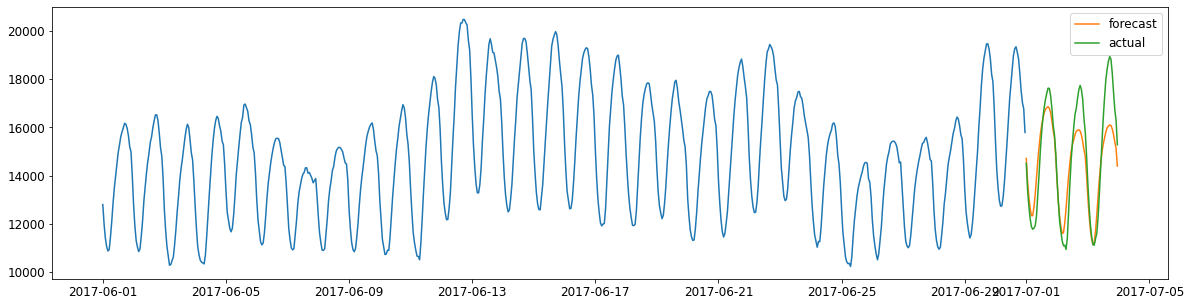

In [12]:
fcst = engine.predict(df_pp)
plt.figure(figsize=(20,5))
plt.plot(df_pp.iloc[-24*30:].index, df_pp.iloc[-24*30:].values)
plt.plot(fcst.index, fcst.values, label='forecast')
plt.plot(df_raw.loc['2017-07-01':'2017-07-03'].index, df_raw.loc['2017-07-01':'2017-07-03'].values, label='actual')
plt.legend()